In [1]:
import os
import random
import shutil

# Paths to your dataset directories
data_dir = "/kaggle/input/deepfake-and-real-images/Dataset"  # Update with your dataset directory path
train_real_dir = os.path.join(data_dir, "Train", "Real")
train_fake_dir = os.path.join(data_dir, "Train", "Fake")
val_real_dir = os.path.join(data_dir, "Validation", "Real")
val_fake_dir = os.path.join(data_dir, "Validation", "Fake")

# Define target directories for the reduced dataset
reduced_data_dir = "/kaggle/working/reduced_dataset"
reduced_train_real_dir = os.path.join(reduced_data_dir, "train", "real")
reduced_train_fake_dir = os.path.join(reduced_data_dir, "train", "fake")
reduced_val_real_dir = os.path.join(reduced_data_dir, "validation", "real")
reduced_val_fake_dir = os.path.join(reduced_data_dir, "validation", "fake")

# Create target directories if they don't exist
os.makedirs(reduced_train_real_dir, exist_ok=True)
os.makedirs(reduced_train_fake_dir, exist_ok=True)
os.makedirs(reduced_val_real_dir, exist_ok=True)
os.makedirs(reduced_val_fake_dir, exist_ok=True)

# Set desired number of images
train_size_real, train_size_fake = 17500, 17500
val_size_real, val_size_fake = 7500, 7500

# Helper function to sample and copy images
def sample_and_copy(src_dir, dest_dir, sample_size):
    images = os.listdir(src_dir)
    sampled_images = random.sample(images, sample_size)
    for img in sampled_images:
        shutil.copy(os.path.join(src_dir, img), dest_dir)

# Sample images for training and validation
sample_and_copy(train_real_dir, reduced_train_real_dir, train_size_real)
sample_and_copy(train_fake_dir, reduced_train_fake_dir, train_size_fake)
sample_and_copy(val_real_dir, reduced_val_real_dir, val_size_real)
sample_and_copy(val_fake_dir, reduced_val_fake_dir, val_size_fake)

print("Dataset reduced and copied successfully!")

Dataset reduced and copied successfully!


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import OneCycleLR
import copy
from pathlib import Path

# Define device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Paths to your data directories
train_data_dir = Path('/kaggle/working/reduced_dataset/train')
validation_data_dir = Path('/kaggle/working/reduced_dataset/validation')

In [4]:
# Define minimal transformations (rescaling only)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit model input
    transforms.ToTensor(),          # Convert image to PyTorch tensor and scale to [0, 1]
])

In [5]:
# Load datasets
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_data_dir, transform=transform)

In [7]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# Load and modify MobileNetV2
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s] 


In [9]:
# Unfreeze more layers for fine-tuning
for param in model.features[-5:].parameters():  # Unfreezing the last 5 layers
    param.requires_grad = True

In [10]:
# Modify classifier
model.classifier[1] = nn.Sequential(
    nn.Linear(model.last_channel, 512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Dropout layer to reduce overfitting
    nn.Linear(512, 2)
)

In [14]:
# Define device, loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)  # Lowered learning rate
scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=20, steps_per_epoch=len(train_loader))

In [15]:
# Early stopping parameters
best_val_acc = 0
patience = 5
stopping_step = 0
best_model_wts = copy.deepcopy(model.state_dict())

In [16]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    predicted = (outputs > 0.5).float()  # Predicted label is 1 if output > 0.5
    correct = (predicted == labels).float()
    accuracy = correct.sum() / labels.size(0)
    return accuracy.item()

In [21]:
# Training function
def train_and_evaluate(model, epochs=20):
    global best_val_acc, stopping_step, best_model_wts
    for epoch in range(epochs):
        model.train()
        running_loss, correct_preds = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            correct_preds += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct_preds.double() / len(train_dataset)

        # Validation phase
        model.eval()
        val_running_loss, val_correct_preds = 0.0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * images.size(0)
                val_correct_preds += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_dataset)
        val_acc = val_correct_preds.double() / len(val_dataset)

        # Print statistics
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            stopping_step = 0  # Reset patience counter
        else:
            stopping_step += 1
            if stopping_step >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
# Train the model
model = train_and_evaluate(model, epochs=20)

Epoch [1/20], Loss: 0.0968, Accuracy: 0.9627
Validation Loss: 0.1270, Validation Accuracy: 0.9505
Epoch [2/20], Loss: 0.0814, Accuracy: 0.9688
Validation Loss: 0.1415, Validation Accuracy: 0.9461
Epoch [3/20], Loss: 0.0719, Accuracy: 0.9729
Validation Loss: 0.2105, Validation Accuracy: 0.9258
Epoch [4/20], Loss: 0.0632, Accuracy: 0.9753
Validation Loss: 0.2386, Validation Accuracy: 0.9191
Epoch [5/20], Loss: 0.0538, Accuracy: 0.9799
Validation Loss: 0.1928, Validation Accuracy: 0.9357
Epoch [6/20], Loss: 0.0475, Accuracy: 0.9818
Validation Loss: 0.1272, Validation Accuracy: 0.9578
Epoch [7/20], Loss: 0.0386, Accuracy: 0.9849
Validation Loss: 0.1668, Validation Accuracy: 0.9505
Epoch [8/20], Loss: 0.0321, Accuracy: 0.9875
Validation Loss: 0.1210, Validation Accuracy: 0.9625
Epoch [9/20], Loss: 0.0228, Accuracy: 0.9911
Validation Loss: 0.1891, Validation Accuracy: 0.9509
Epoch [10/20], Loss: 0.0201, Accuracy: 0.9923
Validation Loss: 0.1538, Validation Accuracy: 0.9565
Epoch [11/20], Loss

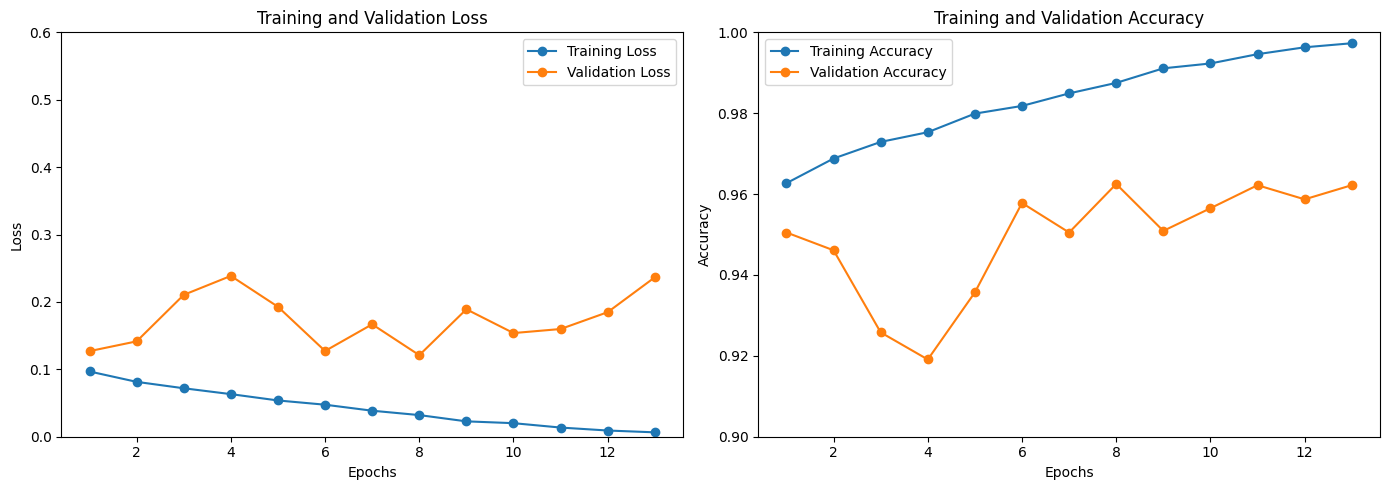

Final Validation Accuracy Confidence Score: 96.22%


In [26]:
import matplotlib.pyplot as plt

# Epoch-wise results
train_losses = [0.0968, 0.0814, 0.0719, 0.0632, 0.0538, 0.0475, 0.0386, 0.0321, 0.0228, 0.0201, 0.0136, 0.0092, 0.0065]
val_losses = [0.1270, 0.1415, 0.2105, 0.2386, 0.1928, 0.1272, 0.1668, 0.1210, 0.1891, 0.1538, 0.1598, 0.1848, 0.2365]
train_accuracies = [0.9627, 0.9688, 0.9729, 0.9753, 0.9799, 0.9818, 0.9849, 0.9875, 0.9911, 0.9923, 0.9946, 0.9963, 0.9973]
val_accuracies = [0.9505, 0.9461, 0.9258, 0.9191, 0.9357, 0.9578, 0.9505, 0.9625, 0.9509, 0.9565, 0.9622, 0.9587, 0.9622]

# Plotting Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 0.6)  # Adjusted scale range for Loss
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim(0.9, 1.0)  # Adjusted scale range for Accuracy
plt.legend()

plt.tight_layout()
plt.show()

# Printing confidence score based on last validation accuracy
confidence_score = val_accuracies[-1] * 100
print(f"Final Validation Accuracy Confidence Score: {confidence_score:.2f}%")


In [31]:
import torch

# Save the model's state_dict (weights)
torch.save(model.state_dict(), '/kaggle/working/model_LaDeDa.pth')